# **1. 데이터셋 준비**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

import os
import json
import zipfile
import random
import numpy as np
from PIL import Image

## **1-1. 데이터셋 불러오기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**이미지 파일 압축 해제**
- 본인 경로를 제대로 설정했는지 확인
- 세션 디스크에 `data > train` 폴더를 만들어두고 압축 해제 진행하셔야 합니다..!
  - 세션 디스크 내 임시 경로로, 드라이브 x

```
!unzip (데이터 경로) -d (압축 해제할 경로)
```

In [ ]:
### 이미지 파일 압축 해제

!unzip /content/drive/MyDrive/Euron/6th-project/data/ver2_0725/train.zip -d /content/data/train
!unzip /content/drive/MyDrive/Euron/6th-project/data/ver2_0725/val.zip -d /content/data/val
# !unzip /content/drive/MyDrive/Euron/6th-project/data/ver2_0725/test.zip -d /content/data/test

Archive:  /content/drive/MyDrive/Euron/6th-project/data/ver2_0725/train.zip
replace /content/data/train/image_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/Euron/6th-project/data/ver2_0725/val.zip
replace /content/data/val/image_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
### annotations 파일 준비

coco_train_path = '/content/drive/MyDrive/Euron/6th-project/data/ver2_0725/coco_train.json'
coco_val_path = '/content/drive/MyDrive/Euron/6th-project/data/ver2_0725/coco_val.json'
# coco_test_path = '/content/drive/MyDrive/Euron/6th-project/data/ver2_0725/coco_test.json'

## **1-2. Custom Dataset 준비**

In [ ]:
### Custom Dataset 클래스 정의

class FashionDataset(Dataset):
  def __init__(self, annotation_file, image_dir, transform = None):
    with open(annotation_file, 'r') as f:
      self.coco_data = json.load(f)
    self.image_dir = image_dir
    self.transform = transform

  def __len__(self):
    return len(self.coco_data['annotations'])

  def __getitem__(self, idx):
    ## 속성 정보
    annotation = self.coco_data['annotations'][idx]

    ## 이미지
    image_id = annotation['image_id']

    image_info = next((img for img in self.coco_data['images'] if img['id'] == image_id), None)
    image_path = os.path.join(self.image_dir, image_info['file_name'])

    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    ## 캡션
    caption = annotation['caption']

    return image, caption

In [ ]:
## 데이터셋 준비

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = FashionDataset(annotation_file = coco_train_path,
                               image_dir = '/content/data/train',
                               transform = transform)

In [ ]:
val_dataset = FashionDataset(annotation_file = coco_val_path,
                               image_dir = '/content/data/val',
                               transform = transform)

In [ ]:
# test_dataset = FashionDataset(annotation_file = coco_test_path,
#                                image_dir = '/content/data/test',
#                                transform = transform)

In [ ]:
## 일부 데이터만 사용하도록 서브셋 생성
# 일단은 shuffle을 수행하지 않았습니다.

def get_subset(dataset, num_samples):
  indices = list(range(len(dataset)))
  # random.shuffle(indices)
  subset_indices = indices[:num_samples]

  return Subset(dataset, subset_indices)

In [ ]:
train_subset = get_subset(train_dataset, 10000)
val_subset = get_subset(val_dataset, 1000)
# test_subset = get_subset(test_dataset, 2000)

In [ ]:
### DataLoader 설정

train_loader = DataLoader(train_subset, batch_size = 32, shuffle = False)
val_loader = DataLoader(val_subset, batch_size = 32, shuffle = False)
# test_loader = DataLoader(test_subset, batch_size = 32, shuffle = False)

# **2. Training(fine-tuning)**

In [ ]:
import torch
from torch.optim import AdamW

from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import get_cosine_schedule_with_warmup # lr scheduler

from tqdm import tqdm
import matplotlib.pyplot as plt

## **2-1. model 준비**

In [ ]:
### Pre-trained model 불러오기

# 전처리기
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", do_rescale=False)

# 모델
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
### 장치 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-23): 24 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (projection): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1024,),

In [ ]:
## 인코더 동결
# 일단은 전체 동결

for name, param in model.named_parameters():
  if "vision_model" in name:
    param.requires_grad = False

## **2-2. 평가 지표 준비**

In [ ]:
!git clone https://github.com/salaniz/pycocoevalcap
!pip install git+https://github.com/salaniz/pycocoevalcap.git

In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

In [ ]:
### 평가 지표 계산

def compute_metrics(preds, labels):
  scorers = [
      (Bleu(4), "BLEU-4"),
      (Meteor(), "METEOR"),
      (Rouge(), "ROUGE"),
      (Cider(), "CIDEr"),
      (Spice(), "SPICE")
  ]

  results = {}
  for scorer, method in scorers:
    score, _ = scorer.compute_score({i: [labels[i]] for i in range(len(labels))}, {i: [preds[i]] for i in range(len(preds))})
    results[method] = score if isinstance(score, float) else score[-1]

  return results

## **2-3. 학습 및 검증**

In [ ]:
### 옵티마이저 및 Learning Rate Schedule 정의

## 옵티마이저
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                  lr = 2e-5, weight_decay = 0.05)

## learning rate schedule
num_training_steps = len(train_loader) * 20  # 20 에포크
num_warmup_steps = int(0.1 * num_training_steps)  # Warmup 비율 10%
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps = num_warmup_steps,
                                            num_training_steps = num_training_steps)

In [ ]:
## 학습 및 검증 손실, 평가 지표 기록

train_losses = []
val_losses = []
best_val_loss = float('inf')

bleu_scores = []
meteor_scores = []
rouge_scores = []
cider_scores = []
spice_scores = []

In [ ]:
### 학습을 위한 함수

def train(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs):
  global best_val_loss

  for epoch in range(num_epochs):
    print(f"=== Epoch {epoch+1} ===")
    print("-" * 20)

    ## Training loop
    model.train()  # 모델 학습 모드로 설정
    epoch_train_loss = 0

    for batch_idx, (images, captions) in enumerate(tqdm(train_loader, desc = f"Training Epoch {epoch+1}/{num_epochs}")):
      images = images.to(device)

      # 전처리
      inputs = processor(images = images, text = captions, return_tensors = "pt", padding = True).to(device)

      # 모델에 입력
      outputs = model(**inputs, labels = inputs.input_ids)

      # 손실 계산 및 역전파
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()  # Learning rate 스케줄링

      epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_train_loss:.4f}")


    ## Validation loop
    model.eval()  # 모델 평가 모드로 설정
    epoch_val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
      for images, captions in tqdm(val_loader, desc = "Validation"):
        images = images.to(device)
        inputs = processor(images = images, text = captions, return_tensors = "pt", padding = True).to(device)

        outputs = model(**inputs, labels = inputs.input_ids)
        loss = outputs.loss
        epoch_val_loss += loss.item()

        # Generate captions
        generated_ids = model.generate(pixel_values = inputs.pixel_values, max_length = 30)
        generated_texts = processor.batch_decode(generated_ids, skip_special_tokens = True)

        # Collect predictions and labels for evaluation
        all_preds.extend(generated_texts)
        all_labels.extend(captions)

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}, Average Validation Loss: {avg_val_loss:.4f}")

    ## Calculate evaluation metrics
    metrics = compute_metrics(all_preds, all_labels)

    bleu_scores.append(metrics['BLEU-4'])
    meteor_scores.append(metrics['METEOR'])
    rouge_scores.append(metrics['ROUGE'])
    cider_scores.append(metrics['CIDEr'])
    spice_scores.append(metrics['SPICE'])

    print(f"BLEU: {metrics['BLEU-4']:.4f}, METEOR: {metrics['METEOR']:.4f}, ROUGE: {metrics['ROUGE']:.4f}, CIDEr: {metrics['CIDEr']:.4f}, SPICE: {metrics['SPICE']:.4f}")


    ## Best model 저장
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      torch.save(model.state_dict(), "best_model.pth")
      print(f"Model saved at Epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    ## Clear cache
    torch.cuda.empty_cache()

In [ ]:
# 모델 학습

num_epochs = 10 # 1 epoch마다 대략 10~12분 정도 걸림
train(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs)

=== Epoch 1 ===
--------------------


Training Epoch 1/10: 100%|██████████| 313/313 [07:45<00:00,  1.49s/it]


Epoch 1, Average Training Loss: 5.2567


Validation: 100%|██████████| 32/32 [01:51<00:00,  3.49s/it]


Epoch 1, Average Validation Loss: 3.3529
{'testlen': 18684, 'reflen': 21269, 'guess': [18684, 17684, 16684, 15684], 'correct': [4270, 631, 106, 29]}
ratio: 0.8784616107950125
BLEU: 0.0153, METEOR: 0.0754, ROUGE: 0.1663, CIDEr: 0.2009, SPICE: 0.0776
Model saved at Epoch 1 with Validation Loss: 3.3529
=== Epoch 2 ===
--------------------


Training Epoch 2/10: 100%|██████████| 313/313 [07:45<00:00,  1.49s/it]


Epoch 2, Average Training Loss: 2.4781


Validation: 100%|██████████| 32/32 [01:51<00:00,  3.48s/it]


Epoch 2, Average Validation Loss: 2.2072
{'testlen': 19880, 'reflen': 21269, 'guess': [19880, 18880, 17880, 16880], 'correct': [4696, 817, 176, 53]}
ratio: 0.9346936856457316
BLEU: 0.0221, METEOR: 0.0848, ROUGE: 0.1756, CIDEr: 0.2755, SPICE: 0.0884
Model saved at Epoch 2 with Validation Loss: 2.2072
=== Epoch 3 ===
--------------------


Training Epoch 3/10: 100%|██████████| 313/313 [07:43<00:00,  1.48s/it]


Epoch 3, Average Training Loss: 2.0040


Validation: 100%|██████████| 32/32 [01:51<00:00,  3.49s/it]


Epoch 3, Average Validation Loss: 2.0882
{'testlen': 20087, 'reflen': 21269, 'guess': [20087, 19087, 18087, 17087], 'correct': [4826, 830, 193, 77]}
ratio: 0.9444261601391253
BLEU: 0.0251, METEOR: 0.0865, ROUGE: 0.1802, CIDEr: 0.2924, SPICE: 0.0847
Model saved at Epoch 3 with Validation Loss: 2.0882
=== Epoch 4 ===
--------------------


Training Epoch 4/10: 100%|██████████| 313/313 [07:43<00:00,  1.48s/it]


Epoch 4, Average Training Loss: 1.7894


Validation: 100%|██████████| 32/32 [01:51<00:00,  3.49s/it]


Epoch 4, Average Validation Loss: 2.0539
{'testlen': 20094, 'reflen': 21269, 'guess': [20094, 19094, 18094, 17094], 'correct': [4909, 885, 242, 105]}
ratio: 0.944755277634071
BLEU: 0.0293, METEOR: 0.0896, ROUGE: 0.1823, CIDEr: 0.3237, SPICE: 0.0925
Model saved at Epoch 4 with Validation Loss: 2.0539
=== Epoch 5 ===
--------------------


Training Epoch 5/10: 100%|██████████| 313/313 [07:42<00:00,  1.48s/it]


Epoch 5, Average Training Loss: 1.6099


Validation: 100%|██████████| 32/32 [01:51<00:00,  3.49s/it]


Epoch 5, Average Validation Loss: 2.0632
{'testlen': 20022, 'reflen': 21269, 'guess': [20022, 19022, 18022, 17022], 'correct': [4853, 855, 226, 103]}
ratio: 0.9413700691146296
BLEU: 0.0283, METEOR: 0.0879, ROUGE: 0.1810, CIDEr: 0.3080, SPICE: 0.0888
=== Epoch 6 ===
--------------------


Training Epoch 6/10: 100%|██████████| 313/313 [07:44<00:00,  1.48s/it]


Epoch 6, Average Training Loss: 1.4413


Validation: 100%|██████████| 32/32 [01:51<00:00,  3.49s/it]


Epoch 6, Average Validation Loss: 2.1009
{'testlen': 19911, 'reflen': 21269, 'guess': [19911, 18911, 17911, 16911], 'correct': [4844, 838, 240, 123]}
ratio: 0.9361512059804911
BLEU: 0.0299, METEOR: 0.0873, ROUGE: 0.1795, CIDEr: 0.3152, SPICE: 0.0881
=== Epoch 7 ===
--------------------


Training Epoch 7/10: 100%|██████████| 313/313 [07:47<00:00,  1.49s/it]


Epoch 7, Average Training Loss: 1.2791


Validation: 100%|██████████| 32/32 [01:52<00:00,  3.50s/it]


Epoch 7, Average Validation Loss: 2.1594
{'testlen': 19553, 'reflen': 21269, 'guess': [19553, 18553, 17553, 16553], 'correct': [4847, 864, 238, 115]}
ratio: 0.9193191969532691
BLEU: 0.0296, METEOR: 0.0880, ROUGE: 0.1812, CIDEr: 0.3152, SPICE: 0.0896
=== Epoch 8 ===
--------------------


Training Epoch 8/10: 100%|██████████| 313/313 [07:43<00:00,  1.48s/it]


Epoch 8, Average Training Loss: 1.1277


Validation: 100%|██████████| 32/32 [01:51<00:00,  3.49s/it]


Epoch 8, Average Validation Loss: 2.2367
{'testlen': 19332, 'reflen': 21269, 'guess': [19332, 18332, 17332, 16332], 'correct': [4728, 826, 227, 107]}
ratio: 0.908928487469984
BLEU: 0.0282, METEOR: 0.0864, ROUGE: 0.1790, CIDEr: 0.2971, SPICE: 0.0873
=== Epoch 9 ===
--------------------


Training Epoch 9/10: 100%|██████████| 313/313 [07:43<00:00,  1.48s/it]


Epoch 9, Average Training Loss: 0.9994


Validation: 100%|██████████| 32/32 [01:51<00:00,  3.49s/it]


Epoch 9, Average Validation Loss: 2.2797
{'testlen': 20703, 'reflen': 21269, 'guess': [20703, 19703, 18703, 17703], 'correct': [4989, 889, 237, 108]}
ratio: 0.9733884996943452
BLEU: 0.0295, METEOR: 0.0896, ROUGE: 0.1812, CIDEr: 0.3069, SPICE: 0.0884
=== Epoch 10 ===
--------------------


Training Epoch 10/10: 100%|██████████| 313/313 [07:43<00:00,  1.48s/it]


Epoch 10, Average Training Loss: 0.9046


Validation: 100%|██████████| 32/32 [01:51<00:00,  3.49s/it]


Epoch 10, Average Validation Loss: 2.2821
{'testlen': 22126, 'reflen': 21269, 'guess': [22126, 21126, 20126, 19126], 'correct': [5005, 848, 234, 107]}
ratio: 1.0402933847383027
BLEU: 0.0277, METEOR: 0.0885, ROUGE: 0.1769, CIDEr: 0.2788, SPICE: 0.0853


## **2-3. 결과 확인**

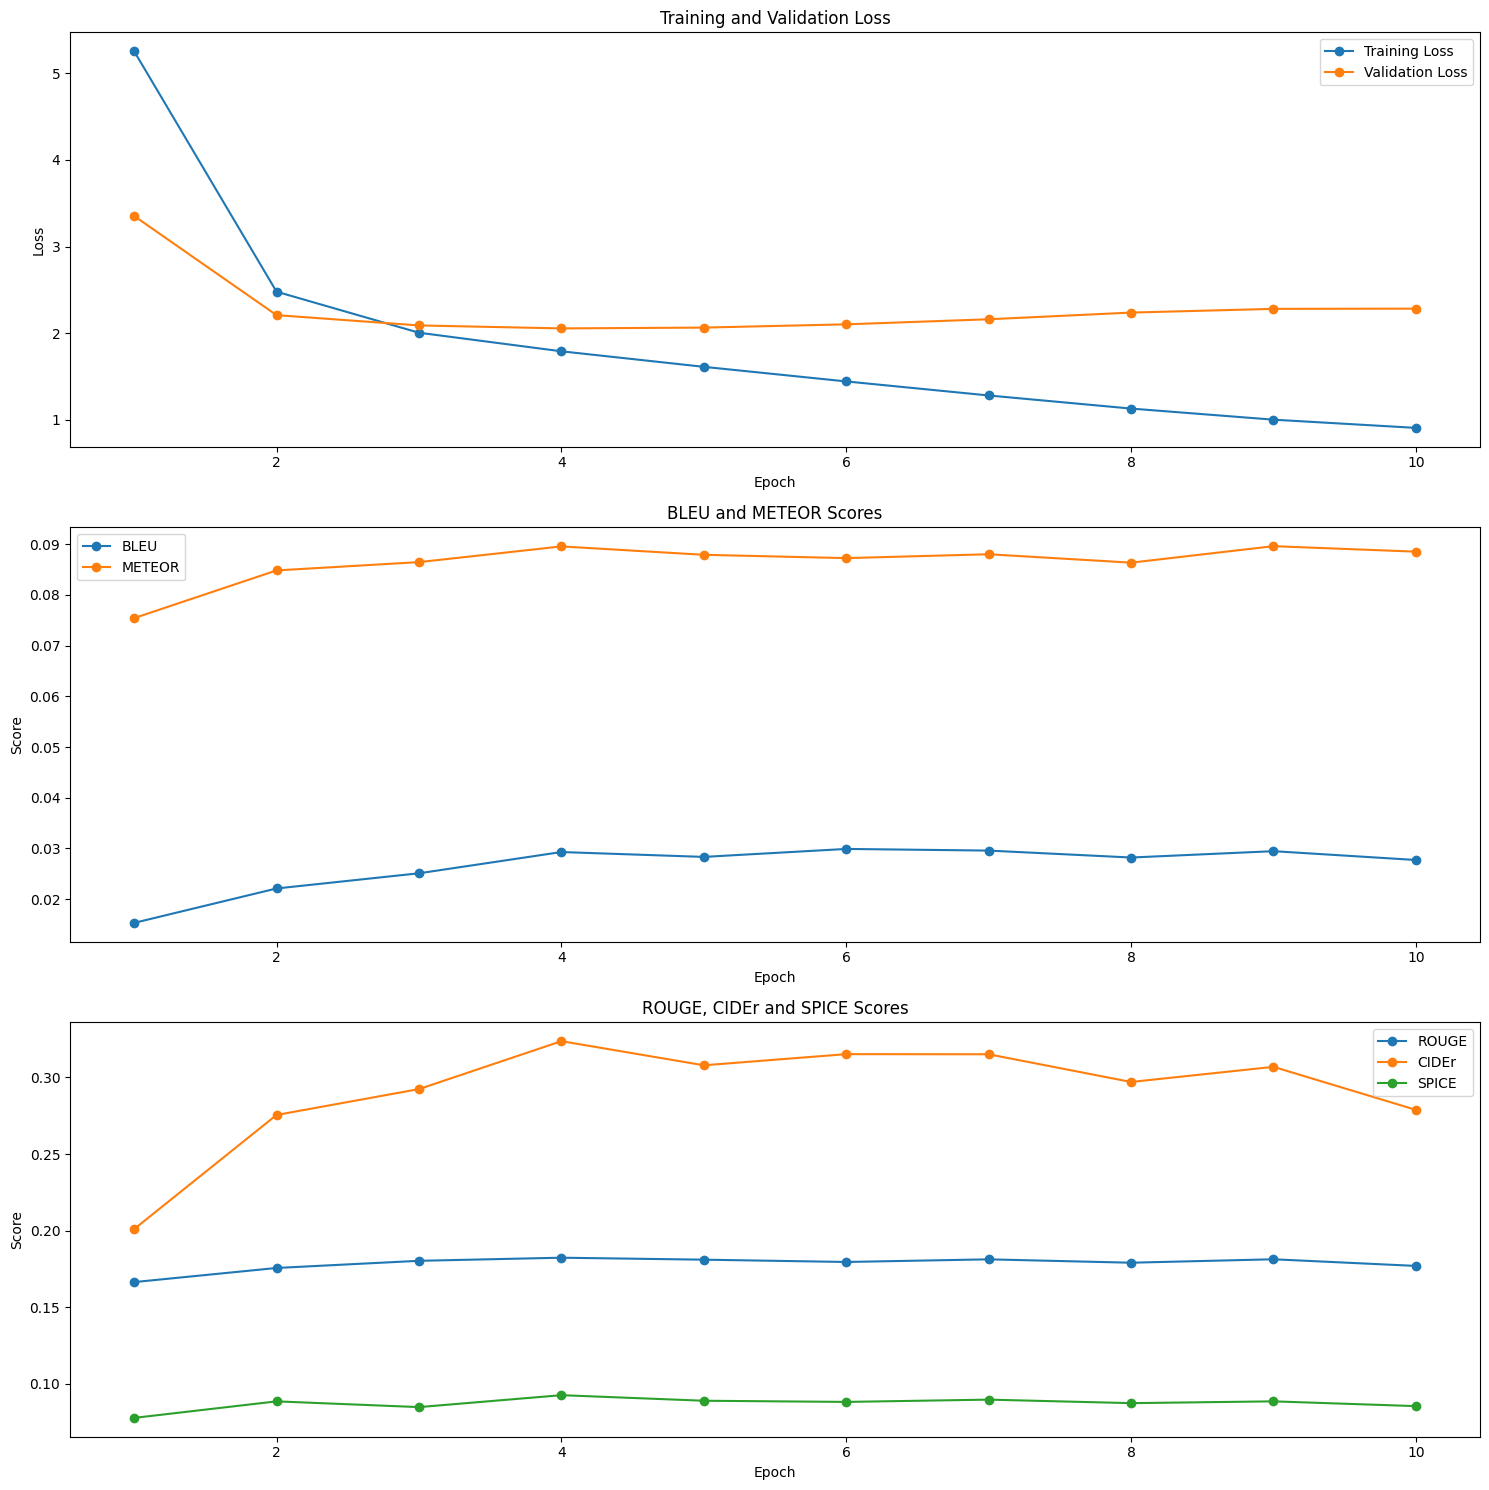

In [ ]:
### 시각화
epochs = range(1, num_epochs + 1)

plt.figure(figsize = (15, 15))

# 손실 곡선
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 평가 지표 1 (BLEU, METEOR)
plt.subplot(3, 1, 2)
plt.plot(epochs, bleu_scores, marker='o', label='BLEU')
plt.plot(epochs, meteor_scores, marker='o', label='METEOR')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('BLEU and METEOR Scores')
plt.legend()

# 평가 지표 2 (ROUGE, CIDEr, SPICE)
plt.subplot(3, 1, 3)
plt.plot(epochs, rouge_scores, marker='o', label='ROUGE')
plt.plot(epochs, cider_scores, marker='o', label='CIDEr')
plt.plot(epochs, spice_scores, marker='o', label='SPICE')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('ROUGE, CIDEr and SPICE Scores')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
### 최종 저장

torch.save(model.state_dict(), "/content/drive/MyDrive/Euron/6th-project/modeling/model/model_0802.pth")